# Data Processing TMQ
From Teagan King and John Truesdale, updated by Katie Dagon (Dec 2022)

## Import libraries

In [34]:
import cftime
import glob
import numpy as np
import xarray as xr
import scipy as sp
import scipy.constants as sc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Set up Dask

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem='25GB' # specify memory here so it duplicates below
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(40)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36653 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/36653/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/36653/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.46:41103,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/36653/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Calculating TMQ

3 hrly TMQ can be calculated from the h4 3hourly average Q. \
Previously used NCL for this: `/glade/campaign/cgd/amp/jet/ClimateNet/data_processing/TMQ.ncl` \
You will need to use PS from the h3 files. \
The script calculates the pressure in each model level and then multiplies by Q and divides by gravity to the mass of in each level. Then it sums all the levels to get the TMQ field.

### Read in files and get pressure values

In [4]:
# cat /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/tmq.ncl

In [4]:
datadir = '/glade/scratch/tking/cgnet/'
qfile_format = '*.Q.*.nc' # Q files are b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4, 3hourly avg from 2080-2100
psfile_format = '*.PS.*.nc'  # PS files are b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3, 3hourly avg from 2080-2100

qfilenames = sorted(glob.glob(datadir+qfile_format))  # sort to retain file order & ensure q and ps files match
psfilenames = sorted(glob.glob(datadir+psfile_format))

In [5]:
qfilenames

['/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.Q.2080010100Z-2080123118Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.Q.2081010100Z-2081123118Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.Q.2082010100Z-2082123118Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.Q.2083010100Z-2083123118Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.Q.2084010100Z-2084123118Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.Q.2085010100Z-2085123118Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.Q.2086010100Z-2086123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.Q.2087010100Z-2087123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.Q.2088010100Z-2088123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.Q.2089010100Z-2089123121Z.nc',
 '/glade/s

In [6]:
psfilenames

['/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2080010100Z-2080123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2081010100Z-2081123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2082010100Z-2082123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2083010100Z-2083123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2084010100Z-2084123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2085010100Z-2085123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2086010100Z-2086123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2087010100Z-2087123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2088010100Z-2088123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2089010100Z-2089123121Z.nc',


In [7]:
# make new .nc files but replace Q with TMQ
tmqnew_files = []
for filename in qfilenames:
    tmqnew_files.append((filename.replace('.Q.', '.TMQ.')).split('/')[-1])

In [8]:
tmqnew_files

['b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2080010100Z-2080123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2081010100Z-2081123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2082010100Z-2082123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2083010100Z-2083123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2084010100Z-2084123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2085010100Z-2085123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2086010100Z-2086123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2087010100Z-2087123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2088010100Z-2088123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2089010100Z-2089123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2090010100Z-2090123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2091010100Z-2091123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2092010100Z-2092123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.

### Test with the first file (year 2080)

In [9]:
qfile1 = xr.open_dataset(qfilenames[0], chunks={"time": 100, "ncol": 100000}) # adjusting chunks for ~100mb size chunks
psfile1 = xr.open_dataset(psfilenames[0], chunks={"time": 100, "ncol": 100000}) # using the same chunk size for consistency

file_1_Q = qfile1['Q'] # Q at each level
file_1_PS = psfile1['PS'] # surface pressure

pref = psfile1['P0'] # reference pressure
plev = psfile1.lev

In [10]:
file_1_Q

<xarray.DataArray 'Q' (time: 2920, lev: 30, ncol: 777602)>
dask.array<open_dataset-767e09284f3a8c571ee4add44b9b7a61Q, shape=(2920, 30, 777602), dtype=float32, chunksize=(100, 30, 100000), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:         1
    units:         kg/kg
    long_name:     Specific humidity
    cell_methods:  time: mean

In [11]:
file_1_PS

<xarray.DataArray 'PS' (time: 2920, ncol: 777602)>
dask.array<open_dataset-84966d86b7e40e22e552a73412d255c6PS, shape=(2920, 777602), dtype=float32, chunksize=(100, 100000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol
Attributes:
    units:         Pa
    long_name:     Surface pressure
    cell_methods:  time: mean

In [12]:
pref.values

array(100000.)

### Get hybrid level coefficients

In [13]:
psfile1['hyai']

<xarray.DataArray 'hyai' (ilev: 31)>
dask.array<open_dataset-84966d86b7e40e22e552a73412d255c6hyai, shape=(31,), dtype=float64, chunksize=(31,), chunktype=numpy.ndarray>
Coordinates:
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 ... 947.4 967.5 985.1 1e+03
Attributes:
    long_name:  hybrid A coefficient at layer interfaces

In [14]:
psfile1['hybi']

<xarray.DataArray 'hybi' (ilev: 31)>
dask.array<open_dataset-84966d86b7e40e22e552a73412d255c6hybi, shape=(31,), dtype=float64, chunksize=(31,), chunktype=numpy.ndarray>
Coordinates:
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 ... 947.4 967.5 985.1 1e+03
Attributes:
    long_name:  hybrid B coefficient at layer interfaces

### Calculate pressure at each level

In [15]:
plev3d=(psfile1['hyai']*pref + psfile1['hybi']*file_1_PS)
plev3d

<xarray.DataArray (ilev: 31, time: 2920, ncol: 777602)>
dask.array<add, shape=(31, 2920, 777602), dtype=float64, chunksize=(31, 100, 100000), chunktype=numpy.ndarray>
Coordinates:
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 ... 947.4 967.5 985.1 1e+03
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol

### Calculate delta pressure at each level

In [16]:
dp3d=(plev3d[1:,:,:].drop_vars('ilev')-plev3d[:-1,:,:].drop_vars('ilev'))
#dp3d

dp3dlev=dp3d.rename({'ilev': 'lev'}) # rename level
dp3dlev

<xarray.DataArray (lev: 30, time: 2920, ncol: 777602)>
dask.array<sub, shape=(30, 2920, 777602), dtype=float64, chunksize=(30, 100, 100000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: lev, ncol

In [17]:
# assign coordinate to dimension
dp3dlev = dp3dlev.assign_coords(coords={'lev' : plev})
dp3dlev

<xarray.DataArray (lev: 30, time: 2920, ncol: 777602)>
dask.array<sub, shape=(30, 2920, 777602), dtype=float64, chunksize=(30, 100, 100000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
Dimensions without coordinates: ncol

In [18]:
# transpose to match Q
dp3dlevT = dp3dlev.transpose('time', 'lev', 'ncol')
dp3dlevT

<xarray.DataArray (time: 2920, lev: 30, ncol: 777602)>
dask.array<transpose, shape=(2920, 30, 777602), dtype=float64, chunksize=(100, 30, 100000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
Dimensions without coordinates: ncol

In [19]:
# double check Q file
file_1_Q

<xarray.DataArray 'Q' (time: 2920, lev: 30, ncol: 777602)>
dask.array<open_dataset-767e09284f3a8c571ee4add44b9b7a61Q, shape=(2920, 30, 777602), dtype=float32, chunksize=(100, 30, 100000), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:         1
    units:         kg/kg
    long_name:     Specific humidity
    cell_methods:  time: mean

### Multiply delta pressure by Q and divide by gravity to get mass of each level

In [20]:
gravity=sc.g
gravity

9.80665

In [21]:
Qdp = file_1_Q * dp3dlevT / gravity
Qdp

<xarray.DataArray (time: 2920, lev: 30, ncol: 777602)>
dask.array<truediv, shape=(2920, 30, 777602), dtype=float64, chunksize=(100, 30, 100000), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol

### Sum over levels to get TMQ

In [22]:
tmq = Qdp.sum(dim='lev')
tmq

<xarray.DataArray (time: 2920, ncol: 777602)>
dask.array<sum-aggregate, shape=(2920, 777602), dtype=float64, chunksize=(100, 100000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol

In [ ]:
# quick unit check
# pressure (Pa) = kg m^−1 s^−2
# gravity = m s^-2
# pressure / gravity = kg m^-2

## Assign some attribues to TMQ
### TO DO: add attributes/metadata to be consistent with CESM netcdf conventions

In [23]:
tmq = tmq.assign_attrs({'long_name' : 'Total (vertically integrated) precipitable water',
                  'units' : 'kg/m2'})
tmq.name="TMQ"
tmq

<xarray.DataArray 'TMQ' (time: 2920, ncol: 777602)>
dask.array<sum-aggregate, shape=(2920, 777602), dtype=float64, chunksize=(100, 100000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol
Attributes:
    long_name:  Total (vertically integrated) precipitable water
    units:      kg/m2

## Compute TMQ before writing out
Be sure to have enough memory available: in hub and dask workers. This step seems to have more failures than running tmq.compute() as part of tmq.to_netcdf().

In [24]:
#%%time
#tmq = tmq.compute()

## Save out TMQ

This is relatively quick once TMQ has been loaded into memory

In [25]:
%%time
tmq.to_netcdf('/glade/scratch/kdagon/cgnet/TMQ_2080_v2.nc')

CPU times: user 38.8 s, sys: 1.49 s, total: 40.3 s
Wall time: 4min 31s


## Regrid the file using `ncremap`

What are the memory needs for running ncremap in a notebook cell? This step is fairly time consuming, but may be similar in the command line. Adding memory to where the notebook is running (i.e., casper pbs spawn of jhub) may help.

In [26]:
%%bash
module load nco/4.7.9
ncremap -m /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/maps/map_ne120_to_0.23x0.31_bilinear.nc -i /glade/scratch/kdagon/cgnet/TMQ_2080_v2.nc -o /glade/scratch/kdagon/cgnet/TMQ_2080_v2_regrid.nc

Input #00: /glade/scratch/kdagon/cgnet/TMQ_2080_v2.nc
Map/Wgt  : /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/maps/map_ne120_to_0.23x0.31_bilinear.nc
Regridded: /glade/scratch/kdagon/cgnet/TMQ_2080_v2_regrid.nc


ncks: INFO Reducing user-requested thread number = 2 to maximum thread number allowed = 1
ncks: WARNING NC_DOUBLE version of "_FillValue" attribute for TMQ fails isfinite(), value is NaN, which can cause unpredictable results.
HINT: If arithmetic results (e.g., from regridding) fails or values seem weird, retry after first converting _FillValue to normal number with, e.g., "ncatted -a _FillValue,TMQ,m,f,1.0e36 in.nc out.nc"


In [27]:
# Read back in for plotting
fn=('/glade/scratch/kdagon/cgnet/TMQ_2080_v2_regrid.nc')
dstmq=xr.open_dataset(fn, chunks={"time": 20}) # adjust for chunk size ~100MB

In [28]:
dstmq.TMQ

<xarray.DataArray 'TMQ' (time: 2920, lat: 768, lon: 1152)>
dask.array<open_dataset-99f7df846026bbbeda374c8bb3ce0761TMQ, shape=(2920, 768, 1152), dtype=float64, chunksize=(20, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    units:          kg/m2
    cell_measures:  area: area

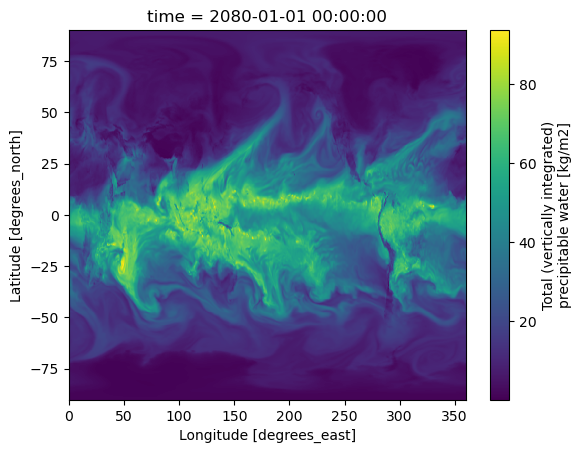

In [29]:
# Quick plot of first time index
dstmq['TMQ'].isel(time=0).plot();

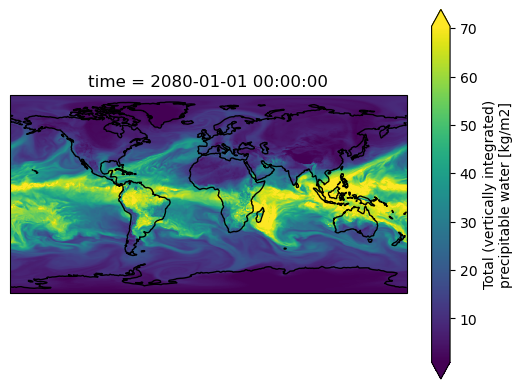

In [30]:
ax=plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
dstmq['TMQ'].isel(time=0).plot(transform=ccrs.PlateCarree(),robust=True);

## Use map file to regrid
From Colin Zarzycki, 12/8/22\
https://github.com/UXARRAY/uxarray/issues/183

In [31]:
## ESMF weightfile
map_path = '/glade/campaign/cgd/amp/jet/ClimateNet/data_processing/maps/'
map_file='map_ne120_to_0.23x0.31_bilinear.nc'
xwgt=xr.open_dataset(map_path+map_file)
xwgt

<xarray.Dataset>
Dimensions:        (src_grid_rank: 1, dst_grid_rank: 2, n_a: 777602,
                    n_b: 884736, nv_a: 3, nv_b: 4, n_s: 2654208)
Dimensions without coordinates: src_grid_rank, dst_grid_rank, n_a, n_b, nv_a,
                                nv_b, n_s
Data variables: (12/19)
    src_grid_dims  (src_grid_rank) int32 ...
    dst_grid_dims  (dst_grid_rank) int32 ...
    yc_a           (n_a) float64 ...
    yc_b           (n_b) float64 ...
    xc_a           (n_a) float64 ...
    xc_b           (n_b) float64 ...
    ...             ...
    area_b         (n_b) float64 ...
    frac_a         (n_a) float64 ...
    frac_b         (n_b) float64 ...
    col            (n_s) int32 ...
    row            (n_s) int32 ...
    S              (n_s) float64 ...
Attributes:
    title:               ESMF Offline Regridding Weight Generator
    normalization:       destarea
    map_method:          Bilinear remapping
    ESMF_regrid_method:  Bilinear
    conventions:         NCAR-CSM
    domain_a:            /glade/p/cgd/ccr/people/nanr/mapfiles/ne120.nc
    domain_b:            /glade/p/cgd/ccr/people/nanr/mapfiles/0.23x0.31.nc
    grid_file_src:       /glade/p/cgd/ccr/people/nanr/mapfiles/ne120.nc
    grid_file_dst:       /glade/p/cgd/ccr/people/nanr/mapfiles/0.23x0.31.nc
    CVS_revision:        6.3.0r

In [32]:
srclat=xwgt['yc_a']
srclon=xwgt['xc_a']
dstlat=xwgt['yc_b']
dstlon=xwgt['xc_b']
src_grid_dims=xwgt['src_grid_dims'].values
dst_grid_dims=xwgt['dst_grid_dims'].values

print("Src grid dims: {0}, dst grid dims: {1}".format(src_grid_dims, dst_grid_dims))

n_a = xwgt['n_a'].size # col dimension
n_b = xwgt['n_b'].size # row dimension
n_s = xwgt['n_s'].size # nnz dimension

print("Map contains {0} rows, {1} cols and {2} nnz values".format(n_b, n_a, n_s))

rows = xwgt['row'][:] - 1 # row indices (1-based)
cols = xwgt['col'][:] - 1 # col indices (1-based)
nnzvals = xwgt['S'][:] # nnz map values

Src grid dims: [777602], dst grid dims: [1152  768]
Map contains 884736 rows, 777602 cols and 2654208 nnz values


In [35]:
## Create sparse matrix map
sparse_map = sp.sparse.coo_matrix((nnzvals, (rows,cols)),shape=(n_b,n_a))
sparse_map

<884736x777602 sparse matrix of type '<class 'numpy.float64'>'
	with 2654208 stored elements in COOrdinate format>

#### Note this is the time consuming step, so sticking to one time index for now

In [36]:
%%time
## Now apply map onto a src column vector length n_a to compute vector length n_b
field_target = sparse_map @ tmq.isel(time=0)

CPU times: user 4.49 s, sys: 176 ms, total: 4.66 s
Wall time: 32.4 s


In [37]:
## Reshape 1-D vector returned to dst_grid_dims
data_out = np.reshape(field_target, dst_grid_dims, order='F')
print("Reshaped array now has dimensions {0}".format(dst_grid_dims, n_a, n_s))

Reshaped array now has dimensions [1152  768]


In [38]:
## Reshape destination grid to build structured xarray da
lat2d = np.reshape(dstlat.values, dst_grid_dims, order='F')
lon2d = np.reshape(dstlon.values, dst_grid_dims, order='F')

In [39]:
## Build da
da = xr.DataArray(
    data=data_out,
    dims=["x", "y"],
    coords=dict(
        lon=(["x"], lon2d[:,0]),
        lat=(["y"], lat2d[0,:]),
    )
)

In [40]:
da

<xarray.DataArray (x: 1152, y: 768)>
array([[1.1169718 , 1.1214458 , 1.13117935, ..., 7.07744253, 7.20029686,
        7.33181943],
       [1.1169718 , 1.12127458, 1.13083692, ..., 7.0774965 , 7.20032384,
        7.33181943],
       [1.1169718 , 1.12110307, 1.13049391, ..., 7.07755778, 7.20035448,
        7.33181943],
       ...,
       [1.1169718 , 1.12170537, 1.1316985 , ..., 7.07665856, 7.19990485,
        7.33181943],
       [1.1169718 , 1.12161914, 1.13152604, ..., 7.07691256, 7.20003186,
        7.33181943],
       [1.1169718 , 1.12153262, 1.13135299, ..., 7.07717389, 7.20016253,
        7.33181943]])
Coordinates:
    lon      (x) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
    lat      (y) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
Dimensions without coordinates: x, y

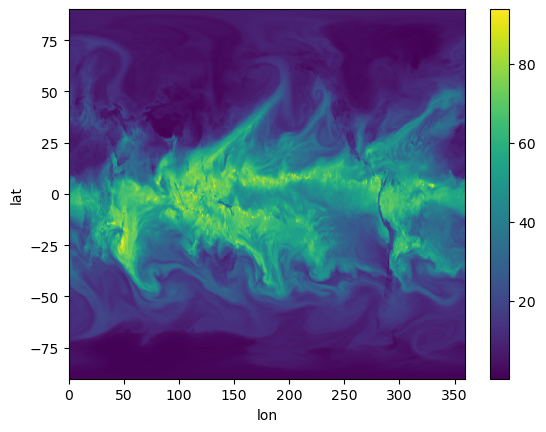

In [41]:
## Simple plot
da.plot(x="lon", y="lat")

## Some notes on writing netcdf files

In [ ]:
# from netCDF4 import Dataset
# import os
# from datetime import datetime
# import numpy as np

# # make a netcdf file

# # CHANGE TO WITHIN FOR STATEMENT WITH ALL FILES ONCE WORKING ON MULTIPLE!
# filename_to_create = '/glade/scratch/tking/cgnet/tmq.nc'
# if os.path.exists(filename_to_create):
#     print('warning, path exists already! not overwriting')
# else:
#     tmq_ncfile = Dataset('/glade/scratch/tking/cgnet/tmq.nc', #+tmqnew_files[0], 
#                      mode='w', format='NETCDF4_CLASSIC')
#     ### MAY NEED TO CHANGE THESE TO TIME 3 NCOL 777602 AND REGRID...
#     # lat_dim = tmq_ncfile.createDimension('lat', 73)     # latitude axis
#     # lon_dim = tmq_ncfile.createDimension('lon', 144)    # longitude axis
#     # time_dim = tmq_ncfile.createDimension('time', None) # unlimited axis (can be appended to).
#     # lev_dim = tmq_ncfile.createDimension('lev', 31)

#     ncol_dim = tmq_ncfile.createDimension('ncol', 777602)
#     time_dim = tmq_ncfile.createDimension('time', 3)
    
#     # other global attributes needed for netcdf files:
#     # data_title = "3-hr averaged/vertically integrated/CESM Water Vapor"
#     # data_summary = "Create input for ClimateNet application, Poisson Fill for NaNs"
#     # data_creator = "Teagan King, tking@ucar.edu"
#     # cesm_contact = "Teagan King, tking@ucar.edu"
#     # data_script = "jupyter notebook at /glade/u/home/tking/cgnet/Data_Processing.ipynb"
#     # source_file =  qfilenames[0] + psfilenames[0]
#     # conventions = "CF 1.0"
#     # creation_date = datetime.today().strftime('%Y-%m-%d')

#     # actually add this info into file...
#     # tmq_ncfile.title = data_title
#     # tmq_ncfile.summary = data_summary
#     # tmq_ncfile.creator = data_creator
#     # tmq_ncfile.contact = cesm_contact
#     # tmq_ncfile.script = data_script
#     # # tmq_ncfile.source = source_file
#     # tmq_ncfile.conventions = conventions
#     # tmq_ncfile.creation_date = creation_date
    
#     # add data to netcdf file under 'TMQ'
#     tmq_var = tmq_ncfile.createVariable('TMQ',np.float64,('time','ncol')) # unlimited dimension is leftmost
#     # tmq_var.units = 'kg/m2'
#     # tmq_var.long_name = 'Total (vertically integrated) precipitable water'

#     tmq_var[:,:] = tmq